Use conda environment `conda_envs/scrnaseq.yml` to run this notebook.

In [ ]:
import pandas as pd
import scanpy as sc
import loompy
import scipy

from tqdm import tqdm

def adjust_shape(csr_mtx):
    if csr_mtx.shape[0] > 1:
        return csr_mtx.mean(axis=0)
    else:
        return csr_mtx    

# Input data:

- `data/polycomb_dots_hand_coords_update_June25.tsv` - Polycomb dot coordinates identified in this paper
- `/tank/projects/schizophrenia_2021/data/siletti2023/adult_human_20221007.loom` -scRNA-seq data from *Siletti et al., 2023*, fetched from [linnarsson-lab/adult-human-brain](https://github.com/linnarsson-lab/adult-human-brain) 

In [2]:
data_dir = '../../data/'
polycomb_dots = pd.read_csv(data_dir + 'polycomb_dots_hand_coords_update_June25.tsv', sep='\t', index_col=0)

In [8]:
polycombed_genes = [g.strip() for g in pd.concat([polycomb_dots['gene1'], polycomb_dots['gene2']]).str.split(',').explode().unique() if g != '-']

In [11]:
len(set(polycombed_genes))

416

# Get scRNA-seq expressions from `loom` file

In [5]:
loom_path = "/tank/projects/schizophrenia_2021/data/siletti2023/adult_human_20221007.loom"

In [6]:
with loompy.connect(loom_path) as ds:
    print(ds.shape)
    print(ds.ra.keys())
    print(ds.ca.keys())

(59480, 3369219)
['Accession', 'Gene', 'Valid']
['Age', 'CellCycle', 'CellID', 'Chemistry', 'Clusters', 'Donor', 'NGenes', 'ROIGroupCoarse', 'ROIGroupFine', 'Roi', 'SampleID', 'Sex', 'Subclusters', 'Tissue', 'TotalUMI']


In [54]:
with loompy.connect(loom_path) as ds:
    ROIGroupCoarse = ds.ca['ROIGroupCoarse']
    Clusters = ds.ca['Clusters']
    CellID = ds.ca['CellID']
cells_meta = pd.DataFrame({'ROIGroupCoarse': ROIGroupCoarse, 'Clusters_int': Clusters}, index=CellID)

In [12]:
%%time

pcg_genes_expressions = {}
missed_genes = []

ds = loompy.connect(loom_path)
for gene in tqdm(polycombed_genes):
    if gene in ds.ra["Gene"]:
        expressions = scipy.sparse.csr_matrix( ds[ds.ra.Gene == gene, :] )
        pcg_genes_expressions[gene] = expressions
    else:
        missed_genes.append(gene)

ds.close()

100%|██████████| 416/416 [1:13:59<00:00, 10.67s/it] 

CPU times: user 17min 27s, sys: 2min 6s, total: 19min 33s
Wall time: 1h 13min 59s


In [15]:
pcg_genes_expressions = pd.DataFrame({'CSR_Exprs': pcg_genes_expressions})
print(pcg_genes_expressions.shape)

pcg_genes_expressions_dedup = pcg_genes_expressions[~pcg_genes_expressions.index.duplicated(keep='first')]
pcg_genes_expressions_dedup.CSR_Exprs = pcg_genes_expressions_dedup.CSR_Exprs.apply(adjust_shape)

print(pcg_genes_expressions.shape)
print(pcg_genes_expressions_dedup.CSR_Exprs.apply(lambda x: x.shape).value_counts())

(376, 1)
(376, 1)
(1, 3369219)    376
Name: CSR_Exprs, dtype: int64


In [16]:
pcg_genes_expressions_dedup.to_pickle(data_dir + 'polycombed_genes_expressions_June25.pkl')

## Check genes activity

In [20]:
import pandas as pd
import numpy as np
import scanpy as sc
import scipy.sparse as sp

from IPython.display import display

tian_to_siletti = {
'Amy-Exc':  [153, 154, 155, 156, 157, 158, 159, 160, 161, 162],
'L2/3-IT': [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 134],
'L4-IT': [138, 141],
'L5-ET': [],
'L5-IT': [142, 143, 144],
'L5/6-NP': [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96],
'L6-CT': [109, 110],
'L6-IT': [148, 149],
'L6-IT-Car3': [150, 151],
'L6-IT-Car3': [152],
'L6b': [98, 99, 101, 103, 105, 106],
'Lamp5': [286, 287, 288],
'Lamp5-Lhx6': [270, 271, 272, 274, 275],
'Pvalb': [240, 255, 256, 257, 258, 259, 260, 261, 262, 263],
'Pvalb-ChC': [264, 265],
'Sncg': [282, 283],
'Sst': [241, 242, 243, 248, 249, 250, 251, 252, 253, 254],
'Vip': [284, 285, 289, 290, 291, 292, 293, 294, 295, 296],
'Chd7': [],
'Foxp2': [229],
'MSN-D1': [209, 210, 211, 214, 215, 219, 220, 227, 228, 230, 231, 232, 234],
'MSN-D2': [207, 208, 212, 213, 216, 217, 221],
'SubCtx-Cplx': [],
'ASC': [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64],
'OPC': [32, 33, 34, 35, 36],
'ODC': [40, 44, 45, 46, 47, 48, 49, 50],
'MGC': [4, 5, 6, 7, 8, 9, 10, 11, 12],
'PC': [],
'VLMC': [21, 22, 23, 25, 26, 27, 28],
'EC': [14, 15, 16, 17]
}
siletti_to_tian = {v: k for k, vs in tian_to_siletti.items() for v in vs}

In [57]:
cells_meta['Clusters'] = cells_meta.Clusters_int.astype('int').map(siletti_to_tian)
#cells_meta= cells_meta.dropna()

In [59]:
cells_meta

,ROIGroupCoarse,Clusters_int,Clusters
10X376_7:GAACGTTGTATCGCTA,Cerebral cortex,0,NaN
10X376_8:GAATCGTTCGATACGT,Cerebral cortex,0,NaN
10X393_5:GCGTTTCCATAGATGA,Cerebellum,0,NaN
10X377_4:CTCAACCTCATTTCCA,Thalamus,0,NaN
10X220_8:CGGGACTTCGGTGAAG,Cerebral nuclei,0,NaN
...,...,...,...
10X362_2:TCACACCGTGAGTGAC,Thalamus,460,NaN
10X362_2:TATCAGGTCAATCTTC,Thalamus,460,NaN
10X361_4:TCCCAGTAGTGATGGC,Thalamus,460,NaN
10X377_1:GATCAGTAGATGAATC,Thalamus,460,NaN


In [62]:
CSR_Exprs = sp.vstack(pcg_genes_expressions.CSR_Exprs.values)
CSR_Exprs = pd.DataFrame(CSR_Exprs.toarray(), index=pcg_genes_expressions.index, columns=list(cells_meta.index)).T

CSR_Exprs = CSR_Exprs.loc[cells_meta.dropna().index]
CSR_Exprs_gb = CSR_Exprs.join(cells_meta).groupby(['ROIGroupCoarse', 'Clusters']).agg(np.mean)

CSR_Exprs_gb.to_csv(data_dir + 'polycombed_genes_expressions_update_MeanBy_CtReg.csv')
CSR_Exprs_gb = pd.read_csv(data_dir + 'polycombed_genes_expressions_update_MeanBy_CtReg.csv', index_col=[0,1])

In [64]:
CSR_Exprs_gb

AC003986.3  AC004080.2  AC004080.4  AC004080.5  \
ROIGroupCoarse Clusters                                                    
Cerebellum     ASC           0.00000         0.0         0.0         0.0   
               EC            0.00000         0.0         0.0         0.0   
               MGC           0.00000         0.0         0.0         0.0   
               MSN-D2        0.00000         0.0         0.0         0.0   
               ODC           0.00000         0.0         0.0         0.0   
...                              ...         ...         ...         ...   
Thalamus       Pvalb-ChC     0.00000         0.0         0.0         0.0   
               Sncg          0.00000         0.0         0.0         0.0   
               Sst           0.00000         0.0         0.0         0.0   
               VLMC          0.00597         0.0         0.0         0.0   
               Vip           0.00000         0.0         0.0         0.0   

                          AC005224.2  AC007405.2  AC008060.2  AC008060.3  \
ROIGroupCoarse Clusters                                                    
Cerebellum     ASC          0.001824    0.000456    0.000152    0.007753   
               EC           0.000000    0.000000    0.000000    0.000000   
               MGC          0.000603    0.000000    0.000603    0.000402   
               MSN-D2       0.000000    0.000000    0.000000    0.000000   
               ODC          0.000045    0.000223    0.000312    0.034321   
...                              ...         ...         ...         ...   
Thalamus       Pvalb-ChC    0.000000    0.000000    0.000000    0.000000   
               Sncg         0.000000    0.015152    0.000000    0.000000   
               Sst          0.000000    0.000000    0.000000    0.000000   
               VLMC         0.000271    0.000271    0.000000    0.000000   
               Vip          0.023715    0.036891    0.001318    0.000000   

                          AC008406.3  AC008808.1  ...     ZFHX4  ZFHX4-AS1  \
ROIGroupCoarse Clusters                           ...                        
Cerebellum     ASC               0.0         0.0  ...  0.150958   0.013074   
               EC                0.0         0.0  ...  0.000000   0.000000   
               MGC               0.0         0.0  ...  0.005828   0.001809   
               MSN-D2            0.0         0.0  ...  0.000000   0.000000   
               ODC               0.0         0.0  ...  0.818129   0.034455   
...                              ...         ...  ...       ...        ...   
Thalamus       Pvalb-ChC         0.0         0.0  ...  0.043011   0.000000   
               Sncg              0.0         0.0  ...  0.151515   0.030303   
               Sst               0.0         0.0  ...  0.029412   0.009804   
               VLMC              0.0         0.0  ...  0.186160   0.009227   
               Vip               0.0         0.0  ...  0.418972   0.057971   

                              ZIC1      ZIC2      ZIC4  ZIC4-AS1      ZIC5  \
ROIGroupCoarse Clusters                                                      
Cerebellum     ASC        0.970660  0.024171  0.047887  0.000000  0.025084   
               EC         0.078212  0.472067  0.044693  0.000000  0.142458   
               MGC        0.025924  0.009847  0.007838  0.000000  0.002613   
               MSN-D2     0.000000  0.000000  0.000000  0.000000  0.000000   
               ODC        0.617022  0.009506  0.080827  0.000045  0.005400   
...                            ...       ...       ...       ...       ...   
Thalamus       Pvalb-ChC  0.021505  0.000000  0.000000  0.000000  0.000000   
               Sncg       0.030303  0.000000  0.000000  0.000000  0.000000   
               Sst        0.049020  0.009804  0.000000  0.000000  0.000000   
               VLMC       2.621710  0.410312  0.312347  0.000814  0.086296   
               Vip        0.005270  0.009223  0.003953  0.000000  0.000000   

                  

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
max_values = CSR_Exprs_gb.max(axis=0).sort_values()
hox_genes = max_values[max_values.index.to_series().apply(lambda x: x.startswith('HOX'))].index

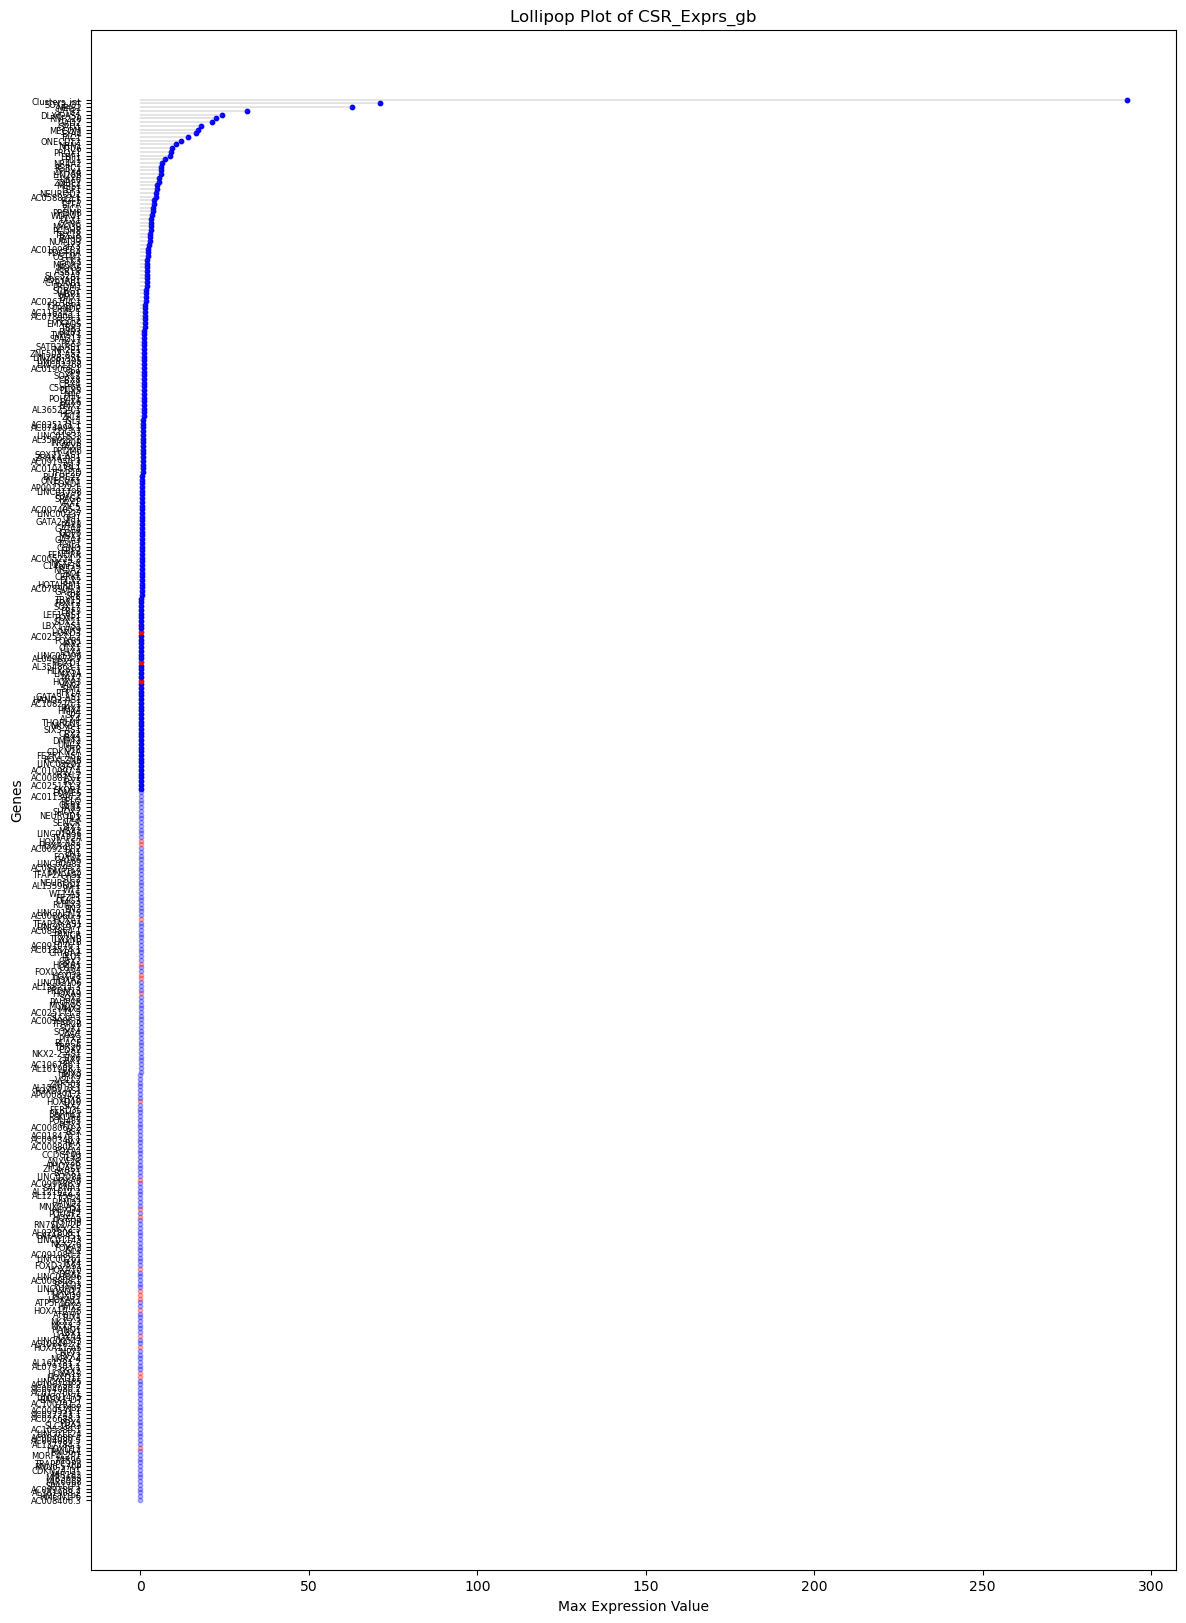

In [68]:
plt.figure(figsize=(14, 20))
threshold = 0.075

for gene in max_values.index:
    dot_color = 'red' if gene in hox_genes else 'blue'
    alpha = .3 if max_values[gene] <= threshold else 1
    plt.plot([0, max_values[gene]], [gene, gene], color='grey', lw=.3)
    plt.scatter(max_values[gene], gene, color=dot_color, alpha=alpha, s=10)

plt.yticks(fontsize=6)
plt.title('Lollipop Plot of CSR_Exprs_gb')
plt.ylabel('Genes')
plt.xlabel('Max Expression Value')
plt.show()

In [83]:
def classify_activity(exprs):
    if all(exprs > threshold):
        return 'Active'
    elif any(exprs > threshold):
        return 'Part. active'
    else:
        return 'Non-active'

Non-active      191
Part. active    185
Active            1
dtype: int64

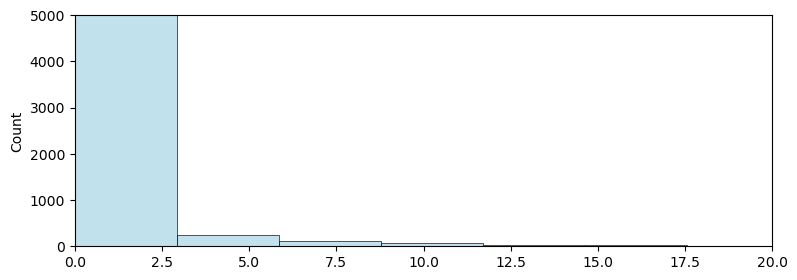

In [84]:
plt.figure(figsize=(9, 3))
sns.histplot(CSR_Exprs_gb.values.ravel(), bins=100, color='lightblue')
plt.ylim(0, 5000)
plt.xlim(0, 20)

CSR_Exprs_gb_cc_classes = CSR_Exprs_gb.apply(classify_activity, axis=0)
display(CSR_Exprs_gb_cc_classes.value_counts())

In [85]:
blacklist = ['Amy-Exc', 'MSN-D1', 'MSN-D2', 'SubCtx-Cplx', 'Foxp2']
CSR_Exprs_gb_cc = CSR_Exprs_gb.loc['Cerebral cortex']
CSR_Exprs_gb_cc = CSR_Exprs_gb_cc.loc[[i for i in CSR_Exprs_gb_cc.index if i not in blacklist]]

Non-active      242
Part. active    125
Active           10
dtype: int64

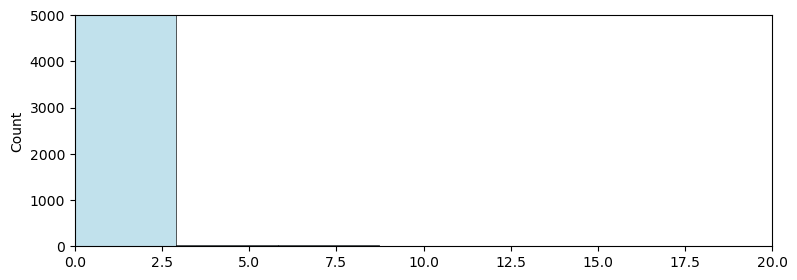

In [86]:
plt.figure(figsize=(9, 3))
sns.histplot(CSR_Exprs_gb_cc.values.ravel(), bins=100, color='lightblue')
plt.ylim(0, 5000)
plt.xlim(0, 20)

CSR_Exprs_gb_cc_classes = CSR_Exprs_gb_cc.apply(classify_activity, axis=0)
display(CSR_Exprs_gb_cc_classes.value_counts())

In [87]:
CSR_Exprs_gb_cc_classes.to_frame().to_csv('polycombed_genes_activity_in_cerebral_cortex.csv', header=None)

In [88]:
CSR_Exprs_gb_cc_classes[CSR_Exprs_gb_cc_classes.index.to_series().apply(lambda x: x.startswith('HOX'))]

HOXA-AS2       Non-active
HOXA-AS3       Non-active
HOXA1          Non-active
HOXA10         Non-active
HOXA10-AS      Non-active
HOXA11         Non-active
HOXA11-AS      Non-active
HOXA13         Non-active
HOXA2          Non-active
HOXA3          Non-active
HOXA4          Non-active
HOXA5          Non-active
HOXA6          Non-active
HOXA7          Non-active
HOXA9          Non-active
HOXD1        Part. active
HOXD10         Non-active
HOXD11         Non-active
HOXD12         Non-active
HOXD13         Non-active
HOXD3          Non-active
HOXD4          Non-active
HOXD8          Non-active
HOXD9          Non-active
dtype: object